# Modeling Epileptic seizures using TVB

**EBRAINS & IBRO Second Virtual Master Class on Brain Atlasing and Simulation Services, September 3, 2021**

## Context

<p><div style="text-align: justify"><font size="4.5" face="time roman">TVB can be used to model <b>large-scale epileptic seizure dynamics</b>. Using relevant neural mass models, TVB allows to ask multiple questions such as the <b>localisation of the Epileptogenic Zone</b> or the <b>validity of different neuroimaging modalities</b> to assess the epileptogenicity of a brain structure. Here, we will present an example of such a modelisation.</font></div></p>

## Objectives

<p><div style="text-align: justify"><font size="4.5" face="time roman">The main goal of this tutorial is to provide a clear understanding of <b>how we can reproduce clinically relevant senarios</b> such as the modelisation of <b>propagation of an epileptic seizure</b> in the human brain, <b>surgical resection</b> of brain regions, and <b>electrical stimulation</b> of a brain region that can trigger a seizure.</font></div></p>

## How to do it with TVB?

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we want to do is to import the modules we will need for a simulation.</font></div></p>

In [1]:
%pylab inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dze_bazl because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Populating the interactive namespace from numpy and matplotlib


In [2]:
%%capture
# Import a bunch of stuff to ease command line usage.
from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.datatypes.projections as projections
from utils import plot_connectivity
from phase_plane import phase_plane_interactive

import numpy as np
import os
import time as tm

<h1><font size="6" face="arial" color="black"> 1. Exploring the Epileptor model</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">In order to model epilepsy, we choose the <b>Epileptor</b> which is a phenomenological neural mass model able to realistically reproduce <b>epileptic seizure dynamics</b> such as recorded with intracranial EEG electrodes (see <b>Jirsa et al., Brain 2014</b>).</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Before launching any simulations, we will have a look at the <b>phase space</b> of the model in order to better understand its dynamics. We will use the phase plane interactive tool.</font></div></p>

In [3]:
# Create an Epileptor model instance.
epi = models.Epileptor()

# Initialise an Integrator scheme.
dt = 0.075    #integration steps [ms]
heunint = integrators.HeunDeterministic(dt=dt)

# Open the phase plane tool with the Epileptor model.
phase_plane_interactive(model=epi, integrator=heunint)

interactive(children=(FloatSlider(value=0.00035, description='r', max=0.001), FloatSlider(value=-1.6, descript…

<function phase_plane.phase_plane_interactive.<locals>.plot_phase_plane(**param_kwargs)>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Look at the phase space: 
<br>
<ul>
<li>We have here the <b>first population (variables $\pmb{x_{1}}$ in abscissa and $\pmb{y_{1}}$ in ordinate)</b>.

The left most intersection of the two nullclines defines a <b>stable fixed point</b>, representing the <b>interictal state (i.e., between seizures)</b>, whereas the right most intersection is the center of a <b>limit cycle</b>, being the <b>ictal state (i.e., during seizures)</b>. Both states are separated by a separatrix, as you can se by drawing different trajectories in this phase space.</li><br>

<li>You can also have a look at other variables in the phase space, such as the <b>second population (variables $\pmb{x_{2}}$ in abscissa and $\pmb{y_{2}}$ in ordinate)</b>, responsible for the <b>interictal spikes</b> in the Epileptor model. Change the lower and upper bound of the axis to see correctly the phase space.</li>

<br><li>You can continue to play along to explore the dynamics of this model. For instance, try changing the number of integration steps, or choosing a HeunStochastic integrator and varying the scaling of the noise:</li>
</ul></font></div></p>

In [4]:
epi = models.Epileptor()
# Initialise a stochastic Integrator scheme.
dt = 0.01                                           #integration steps [ms]
heunstochint = integrators.HeunStochastic(dt=dt)
heunstochint.noise.nsig = np.r_[0.1]                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor Model and stochastic Integrator.
phase_plane_interactive(model=epi, integrator=heunstochint)

interactive(children=(FloatSlider(value=0.00035, description='r', max=0.001), FloatSlider(value=-1.6, descript…

<function phase_plane.phase_plane_interactive.<locals>.plot_phase_plane(**param_kwargs)>

<h1><font size="6" face="arial" color="black">2. Dataset</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">We will use the <b>default dataset</b> that is supplied with The Virtual Brain. To make things fully transparent, we will load the files from our local copy. To follow, change the path to the location of the dataset on your machine:</font></div></p>

In [5]:
datadir = os.path.abspath("./dataset")

<h1><font size="6" face="arial" color="black">3. Region-based modeling of an epileptic patient</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will model a patient with a <b>bilateral temporal lobe epilepsy (TLE)</b> using the Default TVB Subject.</font></div></p> <br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The basic simulation of TVB consists of 5 main components. Each of these components is an object within TVB:</font></div></p>

<h2><font size="5"face="arial" color="black"> 3.1 Structural Connectivity</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We start with loading and visualizing the structural connectivity matrix.</font></div></p>

In [6]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file(os.path.join(datadir, "connectivity_76.zip"))       
nregions = len(con.areas)                                  #number of regions
con.weights = con.weights - con.weights * np.eye(nregions) #remove self-connections
con.weights = con.weights / np.abs(con.weights.max())      #normalize
con.speed = np.array(np.inf)                                         #set the conduction speed to infinity (i.e., no time delay)
con.configure()

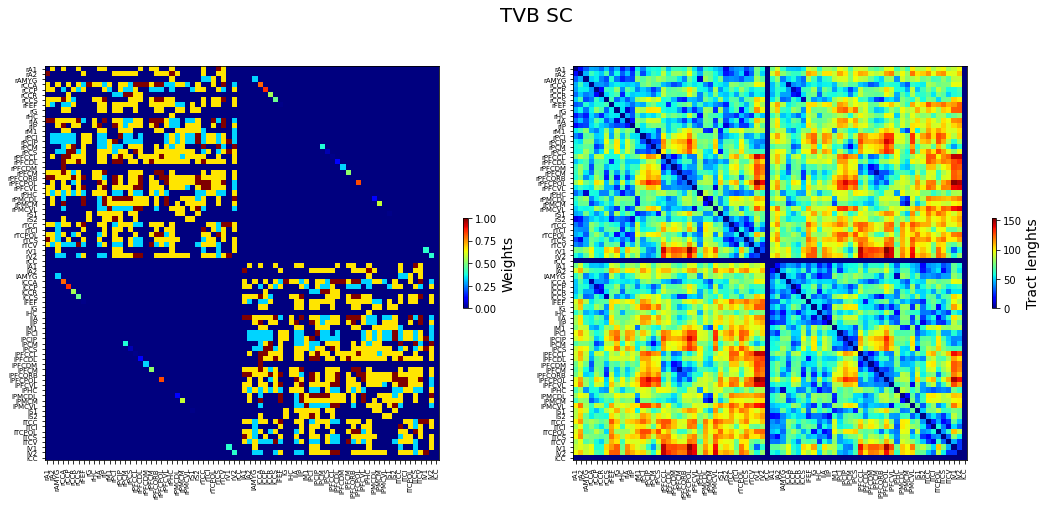

In [7]:
# Visualization.
plot_connectivity(con)

<h2><font size="5" face="arial" color="black"> 3.2 Model</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">A set of differential equations describing the local dynamics. Here, we use the <b>Epileptor</b>.</font></div></p>

In [8]:
# Initialise a Model.
epi = models.Epileptor(Ks=np.array(1.), r=np.array(0.00015))

# Set initial conditions.
epi.state_variable_range["x1"] = [-1.8, -1.4]
epi.state_variable_range["y1"] = [-15., -10.]
epi.state_variable_range["z"] = [3.6, 4.]
epi.state_variable_range["x2"] = [-1.1, -0.9]
epi.state_variable_range["y2"] = [0.001, 0.01]

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can refine the network pathology of the patient by including the hypothesis about the Epileptogenic Network. To this end, we define a <b>spatial map of epileptogenicity</b> where each network's node <i>i</i> is characterized by an excitability value $\pmb{x_{0,i}}$, which quantifies its ability to trigger a seizure. 
<br>We set:
<ul>
<li>the hippocampus (rHC, region 9 and lHC, region 47) as well as the amydala (rAMYG, region 2 and lAMYG, region 40)
as <b>Epileptogenic Zone (EZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-0.75</b> for the rHC and <b>-1.65</b> for the lHC and l-rAMYG,</li> 
<li>we also add two lesser epileptogenic regions: the parahippocampal (lPHC, region 62) and the temporal pole (lTPOL, region 70) as <b>Propagation Zone (PZ)</b>, with an epileptogenicity parameter value $\pmb{x_{0,i}}$ equal to <b>-1.78</b> and <b>-1.81</b>, respectively,</li>
<li>and all the other regions (or <b>Non-Epileptogenic Zone, NEZ</b>) are set to <b>-2.6</b>.</li>
</ul>

In [9]:
# Define a heatmap.
epi.x0 = np.ones(nregions) * (-2.6)            #NEZ
epi.x0[[9]] = np.ones((1)) * (-0.75)           #EZ 
epi.x0[[47, 2, 40]] = np.ones((3)) * (-1.65)   #EZ 
epi.x0[[62]] = np.ones((1)) * (-1.78)          #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)          #PZ 

<h2><font size="5"face="arial" color="black"> 3.3 Coupling function</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">It is a function that is used to join the local model dynamics at distinct spatial locations.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We couple the Epileptors by permittivity coupling, which quantifies the influence of neuronal fast discharges $x_{1,j}$ of a remote region $j$ on the local slow permittivity variable $z_{i}$ of region $i$ via a linear <b>difference coupling</b> function.</font></div></p>

In [10]:
# Initialise a Coupling function.
G = np.array(-0.25)      #global (long-range) coupling strength
con_coupling = coupling.Difference(a=G)

<h2><font size="5"face="arial" color="black"> 3.4 Integrator</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We use a stochastic integration scheme, and the noise is added. The shape of the noise must correspond to the number of state-variables in the neural mass model, here equal to 6. </font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We employ a standard <b>Heun method</b> with an integration time step of <b>0.05</b>. <b>Additive white Gaussian noise</b> is introduced in the state-variables $\pmb{x_{2,i}}$ and $\pmb{y_{2,i}}$ with 0 mean and variance <b>0.00025</b>. Other variables experience only little or no noise due to their high density.</font></div></p>

In [11]:
# Initialise an Integrator scheme.
dt = 0.05               #integration steps [ms]
nsigma = 0.0001        #standard deviation of the noise

hiss = noise.Additive(nsig=np.array([0., 0., 0., nsigma, nsigma, 0.])) 
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)

<h2><font size="5"face="arial" color="black"> 3.5 Monitors</font></h2>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The last component we need to define are some Monitors. Monitors are measurement processes applied to the output data from the simulation.
<pre></pre>

Here, we will select (1) a simple data reduction and (2) a biophysical measurement process to relate the simulated neural activity to recent epilepsy studies: 

<ol type="1">
<li>the <b>TemporalAverage</b> monitor averages over a time window of length <i>period</i> returning one time point every <i>period</i> ms,</li>
<li>the <b>iEEG</b> monitor generates SEEG recordings.</li>
</ol>
</font></div></p>

In [12]:
# Initialise some Monitors with period in physical time.
mon_tavg = monitors.TemporalAverage(period=1) #in ms

mon_seeg = monitors.iEEG.from_file(
    sensors_fname=os.path.join(datadir, "seeg_588.txt"),
    projection_fname=os.path.join(datadir, "projection_seeg_588_surface_16k.npy"),
    rm_f_name=os.path.join(datadir, "regionMapping_16k_76.txt"),
    period=1.)

what_to_watch = (mon_tavg, mon_seeg)

***

<h1 align="center"><font size="6"face="arial" color="black">Go! Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [13]:
# Initialise the Simulator.
sim = simulator.Simulator(model=epi,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors=what_to_watch)

sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: a75c4a61-a607-43fa-8ca7-b774c8bdfedc
coupling,Difference gid: 1d6d66d0-3e5d-499b-b97a-008b159aac1a
gid,UUID('e98e5e49-0d06-4b11-b71c-6a152d0210c3')
initial_conditions,None
integrator,HeunStochastic gid: dcf4a589-6383-4a5d-93dc-010852a6d14f
model,Epileptor gid: 715d5f28-3818-42f9-b071-b7239da0644c
monitors,"(, )"
simulation_length,1000.0


In [14]:
# Starting simulation.
print("Starting simulation...")
tic = tm.time()
(ttavg, tavg), (tseeg, seeg) = sim.run(simulation_length=6000)

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for57.97936129570007


***

<h1 align="center"><font size="6"face="arial" color="black">Visualize our simulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">And finally, we can look at the results of our simulation in terms of time series:</font></div></p>

In [15]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)

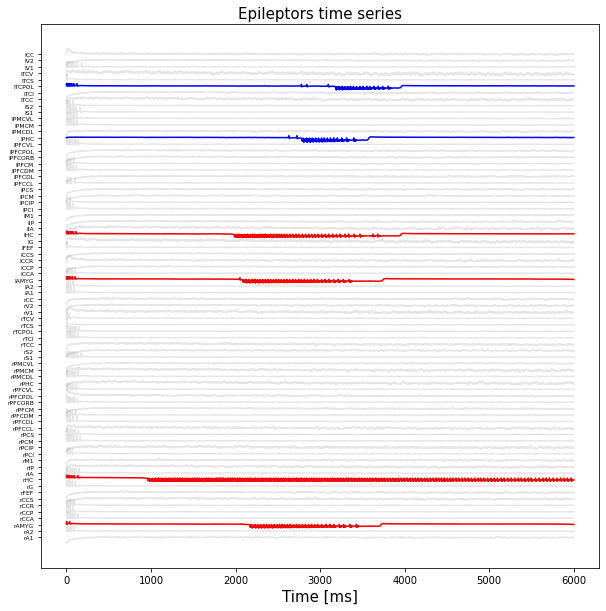

In [16]:
# Plot neural activity time series.
figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.1)
title('Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

EZs = [9, 47, 2, 40]
for ie, ez in enumerate(EZs):
    plot(ttavg[:], tavg[:, 0, EZs[ie], 0] + EZs[ie], 'r') # , 'C3'
PZs = [62, 70]
for ip, pz in enumerate(PZs):
    plot(ttavg[:], tavg[:, 0, PZs[ip], 0] + PZs[ip], 'b') # , 'C0'
    
show()

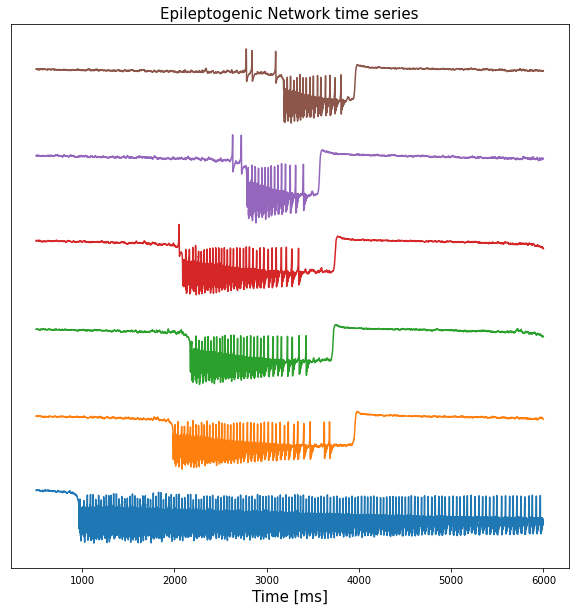

In [17]:
# Zoom on the propagation pattern.
EN = [9, 47, 2, 40, 62, 70]
idx = np.arange(len(EN))

figure(figsize=(10,10))
for ie, en in enumerate(EN):
    plot(ttavg[500:], tavg[500:, 0, EN[ie], 0] + idx[ie]) # , 'C0'
    yticks([])
title('Epileptogenic Network time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)

show()

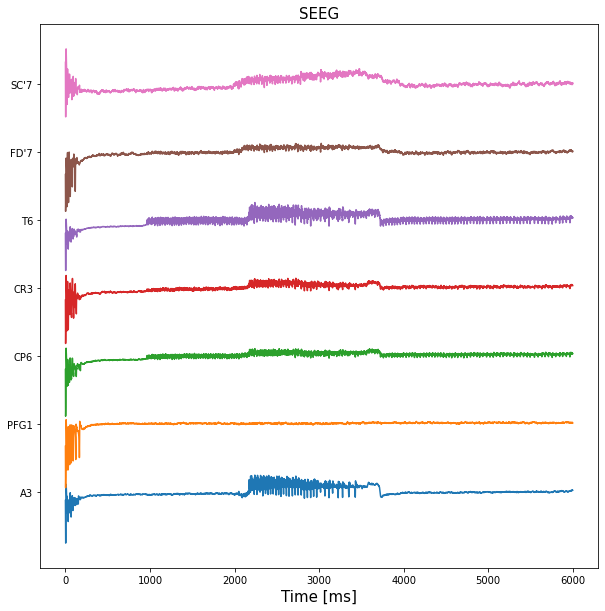

In [18]:
# Plot some of the SEEG sensors.
electrodes = [20, 90, 140, 200, 290, 480, 540]

figure(figsize=(10,10))
plot(tseeg[:], seeg[:, 0, electrodes, 0] + np.r_[:len(electrodes)]) # , 'C0'
yticks(np.r_[:len(electrodes)], mon_seeg.sensors.labels[electrodes])
title('SEEG', fontsize=15)
xlabel('Time [ms]', fontsize=15)
show()

<h1><font size="6" face="arial" color="black">4. Modeling surgical resection</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">Surgical resection is used for around 20% of epileptic patient whose seizures are drug- resistant. We will simulate the hypothetic case of a surgical resection of the Epileptogenic Zone.</font></div></p>

<h3 align="left"><font size="5"face="arial" color="black">4.1 Resection</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We set all the connections to the Epileptogenic Zone to 0 in the connectivity matrix. The resection of the Epileptogenic Network is not complete, will it be enough to prevent seizures?</font></div></p>

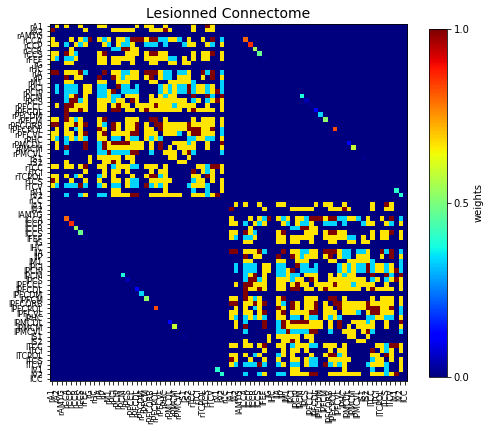

In [19]:
# All the incoming and outcoming connections of the resected regions are removed:
con.weights[:, [9, 47, 2, 40]] = 0.
con.weights[[9, 47, 2, 40], :] = 0.
con.configure()

# Visualization of the resected connectome.
figure(figsize=(8,8))
imshow(con.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Lesionned Connectome', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, 0.5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=8, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=8)

show()

<h3 align="left"><font size="5"face="arial" color="black">4.2 Simulate</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can now relaunch our first simulation, taking care of replacing the dynamic of the EZ by a stable node, as if the region was resected. The rest of the model is set as before, but we just use a time average monitor.</font></div></p>

In [20]:
# Initialise the Model.
epi = models.Epileptor(Ks=np.array(1.), r=np.array(0.00015))

# Define heatmap.
epi.x0 = np.ones(nregions) * (-2.6)       #NEZ
epi.x0[[62]] = np.ones((1)) * (-1.78)     #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)     #PZ 

# Set initial conditions.
epi.state_variable_range["x1"] = [-1.8, -1.8]
epi.state_variable_range["y1"] = [-15, -15]
epi.state_variable_range["z"] = [3.6, 3.6]
epi.state_variable_range["x2"] = [-1.1, -1.1]
epi.state_variable_range["y2"] = [0.001, 0.001]

In [21]:
# Initialise the Simulator.
sim = simulator.Simulator(model=epi,
                          connectivity=con,
                          conduction_speed=np.float(con.speed),
                          coupling=coupling.Difference(a=np.array(-0.25)),
                          integrator=integrators.HeunStochastic(dt=0.05 , noise=noise.Additive(nsig=np.array([0., 0., 0., 0.00025, 0.00025, 0.]))),
                          monitors=(monitors.TemporalAverage(period=1),))

sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: a75c4a61-a607-43fa-8ca7-b774c8bdfedc
coupling,Difference gid: c7cdb720-73ed-44de-ac37-5f600db46879
gid,UUID('d82663a1-70a0-4d96-a43d-99001a0be5d6')
initial_conditions,None
integrator,HeunStochastic gid: fee8c5ad-c7e6-4dce-bfad-fc631169e963
model,Epileptor gid: a5859831-4aef-4ed6-80b0-387e50dbc1ec
monitors,"(,)"
simulation_length,1000.0


In [22]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(ttavg, tavg), = sim.run(simulation_length=10000) # ~ 73 s

# Finished simulation. 
print("Finished simulation.")
print("execute for " + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for 78.03332352638245


<h3 align="left"><font size="5"face="arial" color="black">4.3 Visualize</font></h3>

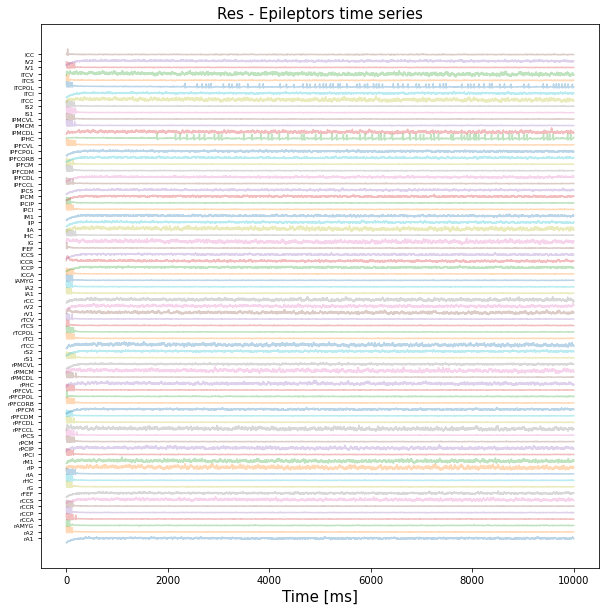

In [23]:
# Normalize the time series to have nice plots.
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
tavg -= np.mean(tavg, 0)

# Plot time series.
figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:nregions], alpha=0.3) # , 'C2'
title('Res - Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see, no seizure is triggered anymore.</font></div></p>

<h1><font size="6" face="arial" color="black">5. Triggering a seizure by stimulation</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We are now going to model an <b>electric stimulation</b> and <b>trigger a seizure</b>. We set the whole brain to non-epileptogenic but the stimulated regions are set closer to the threshold.</font></div></p>

<h3 align="left"><font size="5"face="arial" color="black">5.1 Build a stimulus</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We will begin by just arbitrarily selecting some nodes and defining the weighting of the stimuli coming into those nodes, to show what the basic process looks like.</font></div></p>

In [24]:
# Configure stimulus spatial pattern.
nodes = [62, 70]
stim_weights = np.zeros((nregions))
stim_weights[nodes] = np.array([2.0])

<p><div style="text-align: justify"><font size="4.5" face="time roman">We now need to define the temporal profile. This is done by selecting an equation and setting its parameters as desired. </font></div></p>

In [25]:
# Configure stimulus temporal profile.
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 2e3       # onset time [ms]
eqn_t.parameters['T'] = 3000.0        # pulse repetition period [ms]
eqn_t.parameters['tau'] = 100.0       # pulse duration [ms]

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now, we need to combine these spatial and temporal components into a StimuliRegion object, which can then be used in the construction of our simulator:</font></div></p>

In [26]:
# Configure Stimuli object.
stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = con, 
                                  weight =stim_weights)

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can take a quick look at the basic structure of the stimuli we have just defined using one of the built in plotting tools.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The plotting tool we will use provides a simple overview of the stimuli's structure. It assumes the stimulus object is already configured, so we start by configuring the object. This configuration step is actually taken care of automagically within the simulator, so when you don't want to look at your stimuli before running a simulation this step isn't necessary.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"><i>NOTE:</i> while the information necessary to configure space is provided by the Connectivity object, for time it is necessary to explicitly provide a time vector. When a simulation is run, this time vector is generated internally based on the integration scheme's dt and the simulation length requested when you call the simulator.</font></div></p>

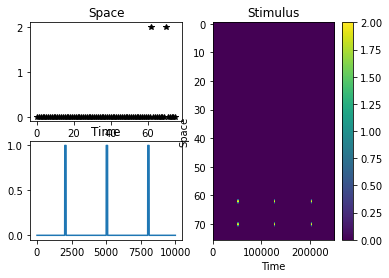

In [27]:
# Configure space and time.
stimulus.configure_space()
stimulus.configure_time(np.arange(0., 10000., 5**-2))

# And take a look
plot_pattern(stimulus)
show()

<h3 align="left"><font size="5"face="arial" color="black">5.2 Simulate</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Now, we just configure ...</font></div></p>

In [28]:
# Initialise Model.
epi = models.Epileptor(Ks=np.array(1.), r=np.array(0.00015))
epi.x0 = np.ones(nregions) * (-2.2) 
epi.x0[nodes] = np.ones((2)) * (-2.07)

# Set initial conditions.
epi.state_variable_range["x1"] = [-1.8, -1.8]
epi.state_variable_range["y1"] = [-15, -15]
epi.state_variable_range["z"] = [3.6, 3.6]
epi.state_variable_range["x2"] = [-1.1, -1.1]
epi.state_variable_range["y2"] = [0.001, 0.001]

In [29]:
# Initialise Simulator.
sim = simulator.Simulator(model=epi, 
                          connectivity=con,
                          coupling=coupling.Difference(a=np.array(-0.25)), 
                          integrator=integrators.HeunStochastic(dt=0.05, noise=noise.Additive(nsig=np.array([0., 0., 0., 0.0001, 0.0001, 0.]))), 
                          monitors=(monitors.TemporalAverage(period=1),), 
                          stimulus=stimulus)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: a75c4a61-a607-43fa-8ca7-b774c8bdfedc
coupling,Difference gid: f4691054-416b-4c53-a0d6-10aa38eefae3
gid,UUID('5bf75fd6-9a6e-4d18-bd66-5a31738428a4')
initial_conditions,None
integrator,HeunStochastic gid: 1a85c9ee-095c-4802-80d3-bd0b723d610a
model,Epileptor gid: 38448ac8-f928-435d-8311-4dbed6072cc2
monitors,"(,)"
simulation_length,1000.0


<p><div style="text-align: justify"><font size="4.5" face="time roman">... and run the simulation.</font></div></p>

In [30]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(t, tavg), = sim.run(simulation_length=10000) # ~80 s

# Finished simulation.  
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for82.26916146278381


<h3 align="left"><font size="5"face="arial" color="black">5.3 Visualize</font></h3>

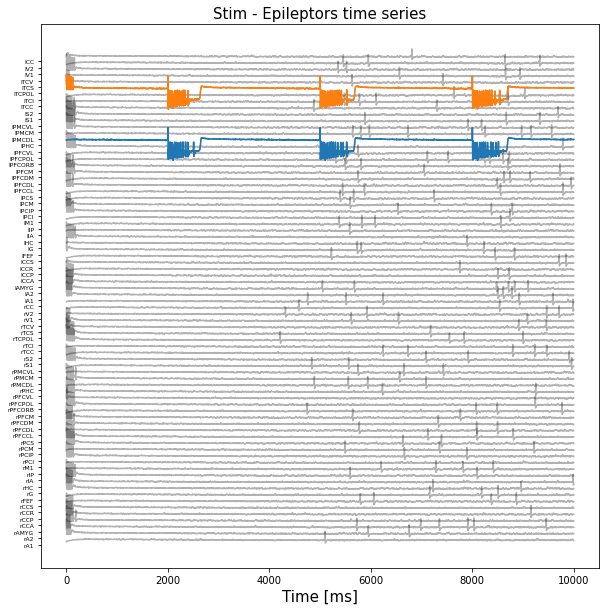

In [31]:
figure(figsize=(10,10))
plot(t[:], tavg[:, 0, :, 0] + np.r_[:nregions], 'k', alpha=0.3)
title('Stim - Epileptors time series', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)

for i, node in enumerate(nodes):
    plot(t[:], tavg[:, 0, nodes[i], 0] + nodes[i]) # , 'C0'
    
show()

<h1><font size="6" face="arial" color="#609BC4">Further exploration</font></h1>

***

<br></br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">
<ul>
<li>Find less invasive resection strategy for stopping the seizure propagation</li>
<ul>
<li>Effects of a lesion are not local and are difficult to predict without a simulation</li>
<li>Comparing the damage of the different surgical procedures</li>
<li>resection versus random lesioning versus lesioning the strongest links</li>
</ul>
</ul>
<ul>
<li>Comparing the impact of the stimuli for trigerring seiuzure</li>
<ul>
<li>How strong must the stimulus be for different nodes, with different heatmaps?</li>
</ul>
</ul>